In [1]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from datetime import datetime
from tqdm import tqdm
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2    
from tensorflow.keras.layers import Conv3D, Conv2D, MaxPooling3D, Dropout, ConvLSTM2D, Softmax, Lambda, UpSampling2D, MaxPooling2D, TimeDistributed, Input
from tensorflow.keras.layers import Conv3D, BatchNormalization, Activation, Conv3DTranspose, Conv2DTranspose, UpSampling3D, Concatenate, LayerNormalization, ReLU, Add, Multiply
from tensorflow.keras import Model
from tensorflow.keras import layers, models
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2
from keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.backend import clear_session
from data_utilities_v2 import *
import glob

In [2]:
clear_session()

In [3]:
# Check if TensorFlow is built with GPU support
print("Built with GPU support:", tf.test.is_built_with_cuda())

# List available physical devices (CPU/GPU)
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print(f"Number of GPUs available: {len(physical_devices)}")
    for i, gpu in enumerate(physical_devices):
        print(f"GPU {i}: {gpu}")
else:
    print("No GPU available.")

Built with GPU support: True
Number of GPUs available: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Loss definitions

In [2]:
# taken from https://github.com/nabsabraham/focal-unet/blob/master/losses.py


epsilon = 1e-5
smooth = 1


def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1.0 - 1e-7)
        loss = -y_true * alpha * K.pow(1 - y_pred, gamma) * K.log(y_pred)
        return K.mean(loss)
    return loss


def dsc(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    smooth = 1.
    axis = (1,2,3,4)
    #y_true_f = K.flatten(y_true)
    #y_pred_f = K.flatten(y_pred)
    y_true_f = tf.reduce_sum(y_true, axis=axis)
    y_pred_f = tf.reduce_sum(y_pred, axis=axis)

    intersection = tf.reduce_sum(y_true * y_pred)

    #score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    score = (2. * intersection + smooth) / (y_true_f + y_pred_f + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 0.8*binary_crossentropy(y_true, y_pred) + 0.2*dice_loss(y_true, y_pred)
    return loss

def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall

def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 

def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 

def tversky(y_true, y_pred):
    # Ensure both y_true and y_pred are of the same type (float32)
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    
    axis = (1,2,3,4)
    P_foreground = y_pred[:,:,:,:,:1]
    P_background = y_pred[:,:,:,:,1:]
    g_foreground = y_true[:,:,:,:,:1]
    g_background = y_true[:,:,:,:,1:]

    #y_true_pos = K.flatten(y_true)
    #y_pred_pos = K.flatten(y_pred)
    true_pos = P_foreground * g_foreground
    true_pos = tf.reduce_sum(true_pos, axis=axis)

    false_pos = P_foreground * g_background
    false_pos = tf.reduce_sum(false_pos, axis=axis)

    false_neg = P_background * g_foreground
    false_neg = 0.5*tf.reduce_sum(false_neg, axis=axis)

    #true_pos = K.sum(y_true_pos * y_pred_pos)
    #false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    #false_pos = K.sum((1 - y_true_pos) * y_pred_pos)

    alpha = 0.8
    smooth = 1e-6

    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 1.33 # 0.75
    return K.pow((1-pt_1), gamma)

def IoU(y_true, y_pred, dtype=tf.float32):
    y_pred = tf.cast(y_pred, dtype)
    y_true = tf.cast(y_true, y_pred.dtype)

    y_pred = tf.squeeze(y_pred)
    y_true = tf.squeeze(y_true)

    y_true_pos = tf.reshape(y_true, [-1])
    y_pred_pos = tf.reshape(y_pred, [-1])

    area_intersect = tf.reduce_sum(tf.multiply(y_true_pos, y_pred_pos))
    
    area_true = tf.reduce_sum(y_true_pos)
    area_pred = tf.reduce_sum(y_pred_pos)
    area_union = area_true + area_pred - area_intersect
    
    # Return the IoU score
    return tf.math.divide_no_nan(area_intersect, area_union)

## Utilities

In [3]:
def Conv3DBlock(
    inputs, n_filters, kernel_size=[3, 3, 3], stride=[1, 1, 1], activation_fn="relu"
):
    """
    Builds the 3d conv block
    Apply successivly a 3D convolution, BatchNormalization and relu
    """
    # Skip pointwise by setting num_outputs=Non
    net = Conv3D(
        filters=n_filters,
        kernel_size=kernel_size,
        strides=stride,
        padding="same",
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
    )(inputs)
    net = BatchNormalization()(net)
    #net = LayerNormalization()(net)
    net = Activation(activation_fn)(net)

    return net

def Conv3DBlockTranspose(
    inputs, n_filters, kernel_size=[3, 3, 3], stride=[1, 1, 1], activation_fn="relu"
):
    """
    Builds the 3d conv transpose block
    Apply successivly a 3D transpose convolution, BatchNormalization and relu
    """
    # Skip pointwise by setting num_outputs=Non
    net = Conv3DTranspose(
        filters=n_filters,
        kernel_size=kernel_size,
        strides=stride,
        padding="same",
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
    )(inputs)
    net = BatchNormalization()(net)
    #net = LayerNormalization()(net)
    net = Activation(activation_fn)(net)

    return net



def AtrousSpatialPyramidPoolingModule_3D(inputs, depth=256):
    """
    5D Tensor: batch, time, H, W, C
    """
    # feature_map_size = tf.shape(inputs)

    # Global average pooling
    image_features = tf.keras.layers.Lambda(
        lambda x: tf.reduce_mean(x, axis=[2, 3], keepdims=True)
    )(inputs)
    
    image_features = Conv3D(
        depth,
        (1, 1, 1),
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
        activation=None,
    )(image_features)

    image_features = UpSampling3D(size=(1, int(inputs.shape[2]), int(inputs.shape[3])))(
        image_features
    )


    atrous_pool_block_1 = Conv3D(depth, (1, 1, 1), kernel_initializer=GlorotUniform(), kernel_regularizer=l2(1e-4), activation=None)(inputs)

    atrous_pool_block_6 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(6, 6, 6), kernel_initializer=GlorotUniform(), kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    atrous_pool_block_12 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(12, 12, 12), kernel_initializer=GlorotUniform(), kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    atrous_pool_block_18 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(18, 18, 18), kernel_initializer=GlorotUniform(), kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    net = Concatenate(axis=-1)(
        [
            image_features,
            atrous_pool_block_1,
            atrous_pool_block_6,
            atrous_pool_block_12,
            atrous_pool_block_18,
        ]
    )

    return net



def AtrousSpatialPyramidPoolingModule_3D_rate_9(inputs, depth=256):
    """
    5D Tensor: batch, time, H, W, C
    """
    # feature_map_size = tf.shape(inputs)

    # Global average pooling
    image_features = tf.keras.layers.Lambda(
        lambda x: tf.reduce_mean(x, axis=[2, 3], keepdims=True)
    )(inputs)

    image_features = Conv3D(
        depth,
        (1, 1, 1),
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
        activation=None,
    )(image_features)

    image_features = UpSampling3D(size=(1, int(inputs.shape[2]), int(inputs.shape[3])))(
        image_features
    )

    atrous_pool_block_1 = Conv3D(
        depth,
        (1, 1, 1),
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
        activation=None,
    )(inputs)

    atrous_pool_block_6 = Conv3D(
        depth,
        (1, 1, 1),
        dilation_rate=(2, 2, 2),
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
        activation=None,
    )(inputs)

    atrous_pool_block_12 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(4, 4, 4), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    atrous_pool_block_18 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(6, 6, 6), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    net = Concatenate(axis=-1)(
        [
            image_features,
            atrous_pool_block_1,
            atrous_pool_block_6,
            atrous_pool_block_12,
            atrous_pool_block_18,
        ]
    )

    return net

def AtrousSpatialPyramidPoolingModule_3D_rate_11(inputs, depth=256):
    """
    5D Tensor: batch, time, H, W, C
    """
    # feature_map_size = tf.shape(inputs)

    # Global average pooling
    image_features = tf.keras.layers.Lambda(
        lambda x: tf.reduce_mean(x, axis=[2, 3], keepdims=True)
    )(inputs)

    image_features = Conv3D(depth, (1, 1, 1),kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None)(image_features)

    image_features = UpSampling3D(size=(1, int(inputs.shape[2]), int(inputs.shape[3])))(
        image_features
    )

    atrous_pool_block_1 = Conv3D(depth, (1, 1, 1), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None)(inputs)

    atrous_pool_block_6 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(4, 4, 4), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    atrous_pool_block_12 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(6, 6, 6), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    atrous_pool_block_18 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(8, 8, 8), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    net = Concatenate(axis=-1)(
        [
            image_features,
            atrous_pool_block_1,
            atrous_pool_block_6,
            atrous_pool_block_12,
            atrous_pool_block_18,
        ]
    )

    return net



def AttentionRefinementModule_3D(inputs, n_filters):
    "for 3d data"
    # 3D Global average pooling
    net = tf.reduce_mean(inputs, axis=[2, 3], keepdims=True)

    net = Conv3D(
        filters=n_filters, kernel_size=(1, 1, 1), padding="same", kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(net)

    #net = LayerNormalization()(net)
    net = BatchNormalization()(net)
    net = tf.sigmoid(net)
    net = tf.multiply(inputs, net)

    return net

def FeatureFusionModule(input_1, input_2, n_filters):

    #inputs = Concatenate()([input_1, input_2])
    inputs = Concatenate(axis=-1)([input_1, input_2])

    inputs = Conv3DBlock(
        inputs, n_filters, kernel_size=[3, 3, 3], stride=[1, 1, 1], activation_fn=None
    )

    # Global average pooling
    net = Lambda(lambda x: tf.reduce_mean(x, axis=[2, 3], keepdims=True))(inputs)

    net = Conv3D(
        filters=n_filters, kernel_size=(1, 1, 1), padding="same", kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(net)
    net = ReLU()(net)

    net = Conv3D(
        filters=n_filters, kernel_size=(1, 1, 1), padding="same", kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(net)
    
    net = Lambda(lambda x: tf.sigmoid(x))(net)

    net = Multiply()([inputs, net])
    net = Add()([inputs, net])

    return net

def FeatureFusionModule_with_Stirde(input_1, input_2, n_filters):

    #inputs = tf.concat([input_1, input_2], axis=-1)
    inputs = Concatenate(axis=-1)([input_1, input_2])

    inputs = Conv3DBlock(
        inputs, n_filters, kernel_size=[3, 3, 3], stride=[1, 2, 2], activation_fn=None
    )

    # Global average pooling
    #net = tf.reduce_mean(inputs, axis=[2, 3], keepdims=True)
    net = Lambda(lambda x: tf.reduce_mean(x, axis=[2, 3], keepdims=True))(inputs)

    net = Conv3D(
        filters=n_filters, kernel_size=(1, 1, 1), padding="same", kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(net)
    net = ReLU()(net)

    net = Conv3D(
        filters=n_filters, kernel_size=(1, 1, 1), padding="same", kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(net)
    
    #net = tf.sigmoid(net)
    net = Lambda(lambda x: tf.sigmoid(x))(net)
    
    net = Multiply()([inputs, net])
    net = Add()([inputs, net])

    return net



def Tversky_Index(prediction, ground_truth, axis=(1, 2, 3, 4)):
    """
    prediction is the probabilities from softmax, here it act as Dice Coef, as alpha and beta
    """
    smooth = 1
    P_foreground = prediction[..., :1]
    P_background = prediction[..., 1:]
    g_foreground = ground_truth[..., :1]
    g_background = ground_truth[..., 1:]

    true_positive = P_foreground * g_foreground
    true_positive = tf.reduce_sum(true_positive, axis=axis)

    false_pos = P_foreground * g_background
    false_pos = 0.5 * tf.reduce_sum(false_pos, axis=axis)

    false_neg = P_background * g_foreground
    false_neg = 0.5 * tf.reduce_sum(false_neg, axis=axis)

    Tversky = tf.divide(
        true_positive + smooth, (true_positive + false_pos + false_neg + smooth)
    )

    return tf.reduce_mean(Tversky)

def dice_coe(output, target, loss_type="sorensen", axis=(1, 2, 3, 4), smooth=1e-5):
    """Soft dice (Sørensen or Jaccard) coefficient for comparing the similarity"""
    inse = tf.reduce_sum(output * target, axis=axis)
    if loss_type == "jaccard":
        l = tf.reduce_sum(output * output, axis=axis)
        r = tf.reduce_sum(target * target, axis=axis)
    elif loss_type == "sorensen":
        l = tf.reduce_sum(output, axis=axis)
        r = tf.reduce_sum(target, axis=axis)
    else:
        raise Exception("Unknow loss_type")
    # new haodong
    dice = (2.0 * inse + smooth) / (l + r + smooth)
    ##
    dice = tf.reduce_mean(dice, name="dice_coe")
    return dice


def iou_coe(output, target, threshold=0.5, axis=(1, 2, 3, 4), smooth=1e-5):
    """Non-differentiable Intersection over Union (IoU) for comparing the similarity"""
    pre = tf.cast(output > threshold, dtype=tf.float32)
    truth = tf.cast(target > threshold, dtype=tf.float32)
    inse = tf.reduce_sum(tf.multiply(pre, truth), axis=axis)  # AND
    union = tf.reduce_sum(
        tf.cast(tf.add(pre, truth) >= 1, dtype=tf.float32), axis=axis
    )  # OR

    batch_iou = (inse + smooth) / (union + smooth)
    iou = tf.reduce_mean(batch_iou, name="iou_coe")
    return iou  # , pre, truth, inse, union


def dice_hard_coe(output, target, threshold=0.5, axis=(1, 2, 3, 4), smooth=1e-5):
    """Non-differentiable Sørensen–Dice coefficient for comparing the similarity"""
    output = tf.cast(output > threshold, dtype=tf.float32)
    target = tf.cast(target > threshold, dtype=tf.float32)
    inse = tf.reduce_sum(tf.multiply(output, target), axis=axis)
    l = tf.reduce_sum(output, axis=axis)
    r = tf.reduce_sum(target, axis=axis)
    hard_dice = (2.0 * inse + smooth) / (l + r + smooth)
    ##
    hard_dice = tf.reduce_mean(hard_dice, name="hard_dice")
    return hard_dice

def confusion(y_true, y_pred):
    smooth = 1

    y_pred_pos = tf.clip_by_value(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos

    y_pos = tf.clip_by_value(y_true, 0, 1)
    y_neg = 1 - y_pos

    tp = tf.reduce_sum(y_pos * y_pred_pos)
    fp = tf.reduce_sum(y_neg * y_pred_pos)
    fn = tf.reduce_sum(y_pos * y_pred_neg)


    prec = (tp + smooth) / (tp + fp + smooth)
    recall = (tp + smooth) / (tp + fn + smooth)

    return prec, recall

def Downsampling_2D(inputs, scale1, scale2):
    return tf.image.resize(
        inputs, size=[scale1, scale2], method=tf.image.ResizeMethod.BILINEAR
    )


def Down_sample_3D(input_layer, scale1, scale2):
    """
    TODO : 10 should be changed to new time scale 10 30 or 200
    """
    unpol_layer = tf.map_fn(
        lambda layer: Downsampling_2D(layer, scale1, scale2),
        input_layer,
        dtype=tf.float32,
    )

    return tf.transpose(tf.stack(unpol_layer), [1, 0, 2, 3, 4])

def skip(layer, end_point):
    return tf.concat([layer, end_point], axis=4)  # -1


def unpool(layer):
    height = layer.shape[1] * 2
    width = layer.shape[2] * 2
    return tf.image.resize(
        layer, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )


def unpool_3D_2(input_layer):

    unpol_layer = tf.map_fn(lambda layer: unpool(layer), input_layer, dtype=tf.float32)
    return tf.transpose(tf.stack(unpol_layer), [1, 0, 2, 3, 4])


def unpool_3D(input_layer):

    unpol_layer = tf.keras.layers.UpSampling3D(size=(1, 2, 2))(input_layer)
    return unpol_layer

def unpool_2D(input_layer):
    """
    2D Unpooling using UpSampling2D.

    Parameters:
    - input_layer: Tensor, feature map to be upsampled.

    Returns:
    - unpol_layer: Tensor, upsampled feature map.
    """
    unpol_layer = tf.keras.layers.UpSampling2D(size=(2, 2))(input_layer)
    return unpol_layer


# Re-define for 5D Tensor, here we are dealing with 5D: axis=3 become axis=4 last channel
def pixel_wise_softmax(output_map):
    return layers.Softmax(axis=-1, name="softmax_output")(output_map)


def weight_variable(shape):

    weights_initializer = tf.keras.initializers.VarianceScaling(
        scale=1.0,
        mode="fan_avg",
        distribution="uniform" if True else "truncated_normal",
        seed=None,
        dtype=tf.float32,
    )
    Weight = tf.Variable(weights_initializer(shape=shape))

    return Weight



def iou_coe_Slice_by_Slice(output, target, threshold=0.5, axis=(2, 3, 4), smooth=1e-5):
    """Non-differentiable Intersection over Union (IoU) for comparing the similarity"""

    pre = tf.cast(output > threshold, dtype=tf.float32)
    truth = tf.cast(target > threshold, dtype=tf.float32)

    inse = tf.reduce_sum(tf.multiply(pre, truth), axis=axis)  # AND
    union = tf.reduce_sum(tf.cast(tf.add(pre, truth) >= 1, dtype=tf.float32), axis=axis)

    batch_iou = (inse + smooth) / (union + smooth)
    iou = tf.reduce_mean(batch_iou, axis=0, name="iou_coe")

    return iou  # , pre, truth, inse, union


def Tversky_Index_Slice_by_Slice(prediction, ground_truth, axis=(2, 3, 4)):
    """
    prediction is the probabilities from softmax, here it act as Dice Coef, as alpha and beta
    """
    smooth = 1
    P_foreground = prediction[..., :1]
    P_background = prediction[..., 1:]
    g_foreground = ground_truth[..., :1]
    g_background = ground_truth[..., 1:]

    true_positive = P_foreground * g_foreground
    true_positive = tf.reduce_sum(true_positive, axis=axis)

    false_pos = P_foreground * g_background
    false_pos = 0.5 * tf.reduce_sum(false_pos, axis=axis)

    false_neg = P_background * g_foreground
    false_neg = 0.5 * tf.reduce_sum(false_neg, axis=axis)

    Tversky = tf.divide(
        true_positive + smooth, (true_positive + false_pos + false_neg + smooth)
    )

    return tf.reduce_mean(Tversky, axis=0)


# Hausdorff Distance
def HausdorffDist(A, B):

    A_squared = np.sum(A**2, axis=1, keepdims=True)
    B_squared = np.sum(B**2, axis=1, keepdims=True)
    D_mat = np.sqrt(A_squared - 2 * np.dot(A, B.T) + B_squared.T)

    # Find DH
    max_dist_A_to_B = np.max(np.min(D_mat, axis=1))
    max_dist_B_to_A = np.max(np.min(D_mat, axis=0))
    dH = np.max([max_dist_A_to_B, max_dist_B_to_A])

    return dH


def ComputeHDD(A, B):
    """A and B has the following Shape
    tensor of 3d: batch, H, W
    """
    return list(map(lambda a, b: HausdorffDist(a, b), A, B))


def process_data_with_spacing(data_file_path):
    """
    Return 3 masks in order SOL, GL and GM.
    Input: main path for the dataset: either Train/Val/or Testm i.e. '/tf/volumes/train/CAT_TH/masksX1.mha'
    """

    # Read the data of formate (528, 640, 1574)
    image_data, HEADER = load(data_file_path)
    # Adjust the formate to (640, 528, 1574)
    image_data = image_data.transpose([1, 0, 2])

    image_data = list(
        map(
            lambda mask_time_step: crop_pad(mask_time_step),
            image_data.transpose(2, 0, 1),
        )
    )  # ,(512,640),

    return np.array(image_data), HEADER.spacing



## Definition of IFSS neural network without masks

In [6]:
# Define the IFSS neural network withou masks
def create_model(input_shape, keep_prob_skip=0.2):   
    x_target = tf.keras.Input(shape=input_shape, name='x_target')  # Only input frames

    ################# Layer 1
    Layer_1 = Conv3DBlock(x_target, n_filters=30, kernel_size=(3, 3, 3), stride=(1, 1, 1), activation_fn=None)
    Layer_1 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same', name='Layer_1p')(Layer_1)
    Layer_1 = AtrousSpatialPyramidPoolingModule_3D(Layer_1, depth=6)
    Layer_1 = Dropout(rate=1 - keep_prob_skip)(Layer_1)

    ################ Layer 2
    Layer_2 = Conv3DBlock(Layer_1, 30, kernel_size=(3, 3, 3), stride=(1, 1, 1), activation_fn=None)
    Layer_2 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same', name='Layer_2p')(Layer_2)
    Layer_2 = AtrousSpatialPyramidPoolingModule_3D(Layer_2, depth=6)
    Layer_2 = Dropout(rate=1 - keep_prob_skip)(Layer_2)

    ############### Layer 3
    Layer_3 = Conv3DBlock(Layer_2, 60, kernel_size=(3, 3, 3), stride=(1, 1, 1), activation_fn=None)
    Layer_3 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same', name='Layer_3p')(Layer_3)
    Layer_3 = AtrousSpatialPyramidPoolingModule_3D_rate_11(Layer_3, depth=12)
    Layer_3 = Dropout(rate=1 - keep_prob_skip)(Layer_3)
    
    ############## Layer 4
    Layer_4 = Conv3DBlock(Layer_3, 120, kernel_size=(3, 3, 3), stride=(1, 1, 1), activation_fn=None)
    Layer_4 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same', name='Layer_4p')(Layer_4)
    Layer_4 = AtrousSpatialPyramidPoolingModule_3D_rate_9(Layer_4, depth=24)
    Layer_4 = Dropout(rate=1 - keep_prob_skip)(Layer_4)

    ############## Layer 5
    Layer_5 = Conv3DBlock(Layer_4, 120, kernel_size=(3, 3, 3), stride=(1, 1, 1), activation_fn=None)
    Layer_5 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same', name='Layer_5p')(Layer_5)
    Layer_5 = AtrousSpatialPyramidPoolingModule_3D_rate_9(Layer_5, depth=24)

    # Apply Bi-ConvLSTM for SpatioTemporal Correlations
    BiSpatioTemporal_x_y_F = ConvLSTM2D(filters=120, kernel_size=(1, 1), padding='same', return_sequences=True, 
                                        go_backwards=False, kernel_initializer='he_normal',
                                        recurrent_dropout=0.3, activation=tf.nn.tanh)(Layer_5)

    BiSpatioTemporal_x_y_B = ConvLSTM2D(filters=120, kernel_size=(1, 1), padding='same', return_sequences=True, 
                                        go_backwards=True, kernel_initializer='he_normal',
                                        recurrent_dropout=0.3, activation=tf.nn.tanh)(Layer_5)

    # Combine forward and backward passes
    BiSpatioTemporal_x_y = tf.keras.layers.Add()([BiSpatioTemporal_x_y_F, BiSpatioTemporal_x_y_B])
    
    
    ########## Layer 6
    Layer_6 = Conv3DBlockTranspose(BiSpatioTemporal_x_y, 120, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_6 = Conv3DBlock(Layer_6, 120, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_6 = FeatureFusionModule(input_1=Layer_6, input_2=BiSpatioTemporal_x_y, n_filters=120)
    Layer_6 = unpool_3D(Layer_6)
    Layer_6 = Dropout(1 - keep_prob_skip)(Layer_6)
    #print(Layer_6)
    
    ######### Layer 7
    Layer_7 = Conv3DBlockTranspose(Layer_6, 120, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_7 = Conv3DBlock(Layer_7, 120, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_7 = FeatureFusionModule(input_1=Layer_7, input_2=Layer_4, n_filters=120)
    Layer_7 = unpool_3D(Layer_7)
    Layer_7 = Dropout(1 - keep_prob_skip)(Layer_7)
    #print(Layer_7)
    
    ######### Layer 8
    Layer_8 = Conv3DBlockTranspose(Layer_7, 60, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_8 = Conv3DBlock(Layer_8, 60, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_8 = FeatureFusionModule(input_1=Layer_8, input_2=Layer_3, n_filters=60)
    Layer_8 = unpool_3D(Layer_8)
    Layer_8 = Dropout(1 - keep_prob_skip)(Layer_8)
    #print(Layer_8)
        
    ######## Layer 9
    Layer_9 = Conv3DBlockTranspose(Layer_8, 60, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_9 = Conv3DBlock(Layer_9, 60, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_9 = FeatureFusionModule(input_1=Layer_9, input_2=Layer_2, n_filters=60)
    Layer_9 = unpool_3D(Layer_9)
    Layer_9 = Dropout(1 - keep_prob_skip)(Layer_9)
    #print(Layer_9)
    
    ######## Layer 10
    Layer_10 = Conv3DBlockTranspose(Layer_9, 16, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_10 = Conv3DBlock(Layer_10, 16, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_10 = FeatureFusionModule(input_1=Layer_10, input_2=Layer_1, n_filters=16)
    Layer_10 = unpool_3D(Layer_10)
    Layer_10 = Dropout(1 - keep_prob_skip)(Layer_10)
    #print(Layer_10)
    
    ######## Layer 11
    Layer_11 = Conv3DBlockTranspose(Layer_10, 8, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_11 = Conv3DBlock(Layer_11, 8, kernel_size=[1,1,1], stride=[1,1,1], activation_fn=None)
    Layer_11 = Dropout(1 - keep_prob_skip)(Layer_11)  
    #print(Layer_11)     

    # Final Output
    net_output_256_logits = Conv3D(num_classes, kernel_size=(1,1,1), activation=tf.nn.relu, 
                                   padding="same", kernel_initializer=GlorotUniform(),
                                   kernel_regularizer=l2(1e-4))(Layer_11)
    
    output = pixel_wise_softmax(net_output_256_logits)

    model = Model(inputs=x_target, outputs=output)
    return model

# Model dimensions
time_step = None  # Keep it flexible
H, W, C = 512, 512, 1
num_classes = 2  

input_shape_x = (time_step, H, W, C)

# Model creation
model = create_model(input_shape_x)

# Model compilation
model.compile()

# Check model summary
model.summary()
print(model.output_shape)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_target (InputLayer)          [(None, None, 512,   0           []                               
                                512, 1)]                                                          
                                                                                                  
 conv3d (Conv3D)                (None, None, 512, 5  840         ['x_target[0][0]']               
                                12, 30)                                                           
                                                                                                  
 batch_normalization (BatchNorm  (None, None, 512, 5  120        ['conv3d[0][0]']                 
 alization)                     12, 30)                                                       

## Load training data

In [7]:
# Define directories for masks and videos
mask_directory = 'C:/Users/admin/Documents/DL_Track/Train_Data_DL_Track/Data_IFSS_crop/train_mask/'
video_directory = 'C:/Users/admin/Documents/DL_Track/Train_Data_DL_Track/Data_IFSS_crop/train_video/'

sub_vol_size = 3
last_ind = sub_vol_size-1

# Loading the masks
mask_dataset = []
mask_number_all = []
m_dataset = []

for path in glob.glob(os.path.join(mask_directory, "video*")):

    frame_mask_dataset = []
    mask_number = []

    for mask_path in glob.glob(os.path.join(path, "*.tif")):

        filename = os.path.splitext(os.path.basename(mask_path))[0]
        number = filename.split('_')[-1]
        number = int(number)
        mask_number.append(number)

        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (512, 512))
        mask = cv2.dilate(mask, np.ones((2,2), np.uint8), iterations=1)
        #mask = np.stack((mask, mask), axis=-1)
        mask = np.clip(np.where(mask>1, mask, 0), 0, 1)
        mask = np.expand_dims(mask, -1)
        mask = np.concatenate([mask, 1-mask], -1)
        mask = np.array(mask)
        # mask = mask/255.0
        frame_mask_dataset.append(mask) 

    frame_mask_dataset = np.array(frame_mask_dataset)
    mask_dataset.append(frame_mask_dataset)
    mask_number_all.append(mask_number)

    stacked_masks_set = []

    # Used for fully supervised learning, comment stacked_masks_set and m_dataset for weakly supervised learning
    # Stack the frames to create a set of 3 frames
    stacked_masks_set = np.array([np.stack([frame_mask_dataset[i], frame_mask_dataset[i+1], frame_mask_dataset[i+2]], axis=0)
                               for i in range(len(frame_mask_dataset) - last_ind)])

    # Append the stacked frames set directly to the image dataset
    m_dataset.append(stacked_masks_set)

# Loading and stacking the image frames
image_dataset = []
video_length = []

for path in glob.glob(os.path.join(video_directory, "video*")):
    
    frame_dataset = []

    for frame_path in glob.glob(os.path.join(path, "*.tif")):

        frame = cv2.imread(frame_path, 1)
        frame = cv2.resize(frame, (512,512))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.reshape((frame.shape[0], frame.shape[1], 1))
        frame = np.array(frame)/255.0
        frame_dataset.append(frame)

    frame_dataset = np.array(frame_dataset)
    single_video_length = len(frame_dataset)
    video_length.append(single_video_length)
    
    # Stack the frames to create a set of 3 frames
    stacked_frames_set = np.array([np.stack([frame_dataset[i], frame_dataset[i+1], frame_dataset[i+2]], axis=0)
                               for i in range(len(frame_dataset) - last_ind)])

    # Append the stacked frames set directly to the image dataset
    image_dataset.append(stacked_frames_set)

# Weakling supervised learning
# Handling masks with missig data
#mask_dataset_complete = []
    
#for i in range(len(mask_number_all)):

    #target_length = video_length[i]
    #target_array = np.empty(target_length, dtype=object)
    #target_mask_set = mask_dataset[i]

    #for j in range(len(mask_number_all[i])):
        #target_array[mask_number_all[i][j]] = target_mask_set[j]
       
    #mask_dataset_complete.append(target_array)

#mask_dataset_complete = np.array(mask_dataset_complete, dtype=object)

# Fully supervised learning
x_train = image_dataset
y_train = m_dataset

# Weakly supervised learning
#x_train = np.array(image_dataset, dtype=object)
#y_train = mask_dataset_complete



(512, 512, 1)
(512, 512)


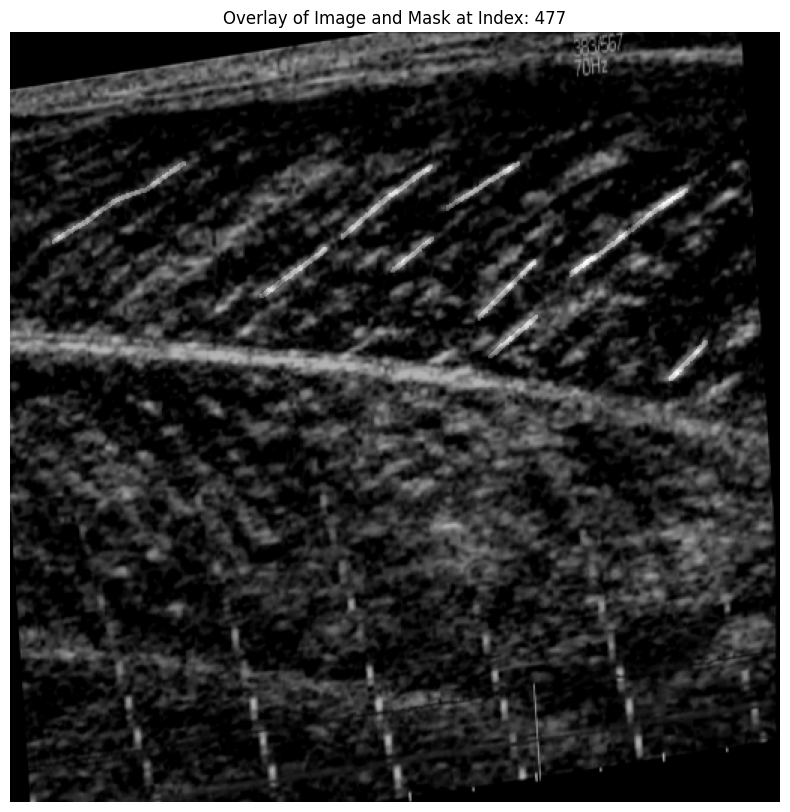

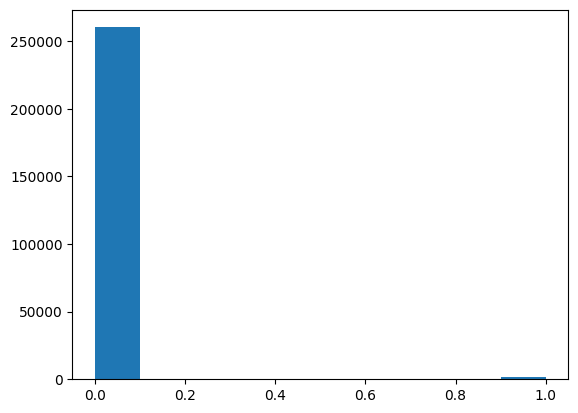

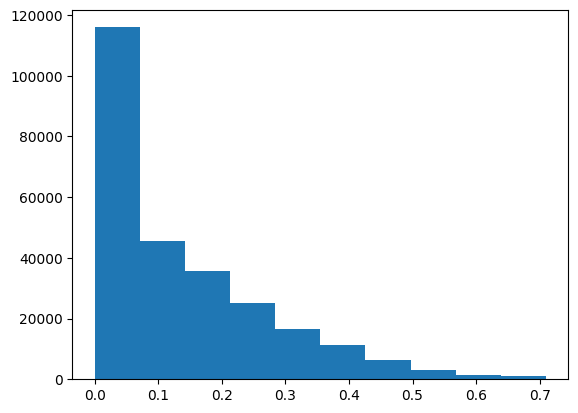

In [8]:
# Function to plot a random image with its corresponding mask overlay
def plot_random_image_with_mask_overlay(x_train, y_train):
    # Flatten the list of all images and masks for easy random selection
    all_images = [frame for video in x_train for frame in video]
    all_masks = [mask for video in y_train for mask in video if mask is not None]
    
    # Select a random index
    random_index = random.randint(0, min(len(all_images), len(all_masks)) - 1)
    
    # Retrieve the corresponding image and mask
    random_image = all_images[random_index][1]  # Select the middle frame from the stack
    random_mask = all_masks[random_index][..., 0][0]  # Assume a single channel mask
    
    # Plot the image with its mask overlay
    plt.figure(figsize=(10, 10))
    plt.title(f"Overlay of Image and Mask at Index: {random_index}")
    
    # Display the image
    plt.imshow(random_image, cmap='gray')
    print(random_image.shape)
    
    # Overlay the mask with some transparency
    plt.imshow(random_mask, cmap='gray', alpha=0.3)  # 'jet' colormap highlights the mask
    print(random_mask.shape)   
      

    plt.axis('off')
    plt.show()
    plt.hist(random_mask.flatten())
    plt.show()
    
    plt.hist(random_image.flatten())
    plt.show()

# Call the function to plot an image with its mask overlay
plot_random_image_with_mask_overlay(x_train, y_train)




## Load Validation Data

In [9]:
# Define directories for masks and videos
mask_directory = 'C:/Users/admin/Documents/DL_Track/Train_Data_DL_Track/Data_IFSS_crop/val_mask/'
video_directory = 'C:/Users/admin/Documents/DL_Track/Train_Data_DL_Track/Data_IFSS_crop/val_video/'

sub_vol_size = 3
last_ind = sub_vol_size-1

# Loading the masks
mask_dataset = []
m_dataset = []
mask_number_all = []

for path in glob.glob(os.path.join(mask_directory, "video*")):

    frame_mask_dataset = []
    mask_number = []

    for mask_path in glob.glob(os.path.join(path, "*.tif")):

        filename = os.path.splitext(os.path.basename(mask_path))[0]
        number = filename.split('_')[-1]
        number = int(number)
        mask_number.append(number)

        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (512,512))
        mask = cv2.dilate(mask, np.ones((2,2), np.uint8), iterations=1)
        #mask = np.stack((mask, mask), axis=-1)
        mask = np.clip(np.where(mask>1, mask, 0), 0, 1)
        mask = np.expand_dims(mask, -1)
        mask = np.concatenate([mask, 1-mask], -1)
        mask = np.array(mask)
        # mask = mask/255.0
        frame_mask_dataset.append(mask) 

    frame_mask_dataset = np.array(frame_mask_dataset)
    mask_dataset.append(frame_mask_dataset)
    mask_number_all.append(mask_number)

    stacked_masks_set = []

    # Used for fully supervised learning, comment stacked_masks_set and m_dataset for weakly supervised learning
    # Stack the frames to create a set of 3 frames
    stacked_masks_set = np.array([np.stack([frame_mask_dataset[i], frame_mask_dataset[i+1], frame_mask_dataset[i+2]], axis=0)
                               for i in range(len(frame_mask_dataset) - last_ind)])

    # Append the stacked frames set directly to the image dataset
    m_dataset.append(stacked_masks_set)

# Loading and stacking the image frames
image_dataset = []
video_length = []

for path in glob.glob(os.path.join(video_directory, "video*")):

    frame_dataset = []

    for frame_path in glob.glob(os.path.join(path, "*.tif")):

        frame = cv2.imread(frame_path, 1)
        frame = cv2.resize(frame, (512,512))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.reshape((frame.shape[0], frame.shape[1], 1))
        frame = np.array(frame)/255.0
        frame_dataset.append(frame)

    frame_dataset = np.array(frame_dataset)
    single_video_length = len(frame_dataset)
    video_length.append(single_video_length)

    stacked_frames_set = []

     # Stack the frames to create a set of 3 frames
    stacked_frames_set = np.array([np.stack([frame_dataset[i], frame_dataset[i+1], frame_dataset[i+2]], axis=0)
                               for i in range(len(frame_dataset) - last_ind)])

    # Append the stacked frames set directly to the image dataset
    image_dataset.append(stacked_frames_set)

# Weakly supervised training
# Handling masks with missing data
#mask_dataset_complete = []
    
#for i in range(len(mask_number_all)):

    #target_length = video_length[i]
    #target_array = np.empty(target_length, dtype=object)
    #target_mask_set = mask_dataset[i]

    #for j in range(len(mask_number_all[i])):
        #target_array[mask_number_all[i][j]] = target_mask_set[j]

    #mask_dataset_complete.append(target_array)

#mask_dataset_complete = np.array(mask_dataset_complete, dtype=object)

# Fully supervised training
x_val = image_dataset
y_val = m_dataset
# Weakly supervised training
#x_val = np.array(image_dataset, dtype=object)
#y_val = mask_dataset_complete


## Plot Masks during training

In [10]:
import matplotlib.pyplot as plt
import os

def plot_batch_with_masks(x_batch, y_true_batch, output_masks, save_dir='batch_plots', epoch=None):
    """
    Plots the 2nd frame (index 1) from the 1st batch with its ground truth and predicted mask.
    """

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # ✅ Select 2nd image (index 1) from first batch
    batches = len(x_batch[-1])
    print(f"Number of batches: {batches}")
    x_image = x_batch[-1]          # Shape: (time, H, W, C)
    y_true = y_true_batch[-1]
    y_pred = output_masks[0]

    # ✅ Select the 2nd frame (index 1) and squeeze
    x_image_selected = x_image[batches-1, 1, ..., 0]
    x_image_selected = np.squeeze(x_image_selected)        # Shape: (H, W)
    y_true_selected = y_true[batches-1, 1, ..., 0]          # Shape: (H, W)
    y_true_selected = np.squeeze(y_true_selected)        # Shape: (H, W)
    y_pred_selected = y_pred[1, ..., 0]          # Shape: (H, W)
    

    # ✅ Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(x_image_selected, cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    axes[1].imshow(y_true_selected, cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(y_pred_selected, cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    # ✅ Save
    title = f"Epoch {epoch+1}" if epoch is not None else "Prediction"
    fig.suptitle(title)
    filename = f"epoch_{epoch+1}_frame_2.png" if epoch is not None else "frame_2.png"
    plt.savefig(os.path.join(save_dir, filename))
    plt.close()


## Training loop

In [ ]:
%tensorboard --logdir logs

In [12]:
import datetime

# TensorBoard log directory
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = tf.summary.create_file_writer(log_dir)


In [13]:
# Variable definitions
#loss_object = tf.keras.losses.binary_crossentropy

optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.Accuracy()
val_acc_metric = tf.keras.metrics.Accuracy()
train_iou_metric = tf.keras.metrics.MeanIoU(num_classes=2, axis=(1, 2, 3, 4))
val_iou_metric = tf.keras.metrics.MeanIoU(num_classes=2, axis=(1, 2, 3, 4))

epochs = 200

# Define ModelCheckpoint class
class ModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, monitor='val_loss', verbose=0, save_best_only=False, mode='min'):
        super(ModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.best = np.Inf if mode == 'min' else -np.Inf
        self.mode = mode

        if mode not in ['auto', 'min', 'max']:
            print(f"ModelCheckpoint mode {mode} is unknown, fallback to auto mode.")
            self.mode = 'auto'

        if self.mode == 'min':
            self.monitor_op = np.less
        elif self.mode == 'max':
            self.monitor_op = np.greater
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
            else:
                self.monitor_op = np.less

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            print(f"Warning: Monitor value {self.monitor} is not available in logs. Skipping checkpoint saving.")
            return
        
        filepath = self.filepath.format(epoch=epoch)

        if self.save_best_only:
            if self.monitor_op(current, self.best):
                if self.verbose > 0:
                    print(f"\nEpoch {epoch}: {self.monitor} improved from {self.best:.5f} to {current:.5f}, saving model to {filepath}")
                self.best = current
                self.model.save(filepath)
            else:
                if self.verbose > 0:
                    print(f"\nEpoch {epoch}: {self.monitor} did not improve from {self.best:.5f}")
        else:
            if self.verbose > 0:
                print(f"\nEpoch {epoch}: saving model to {filepath}")
            self.model.save(filepath)

# Define CSVLogger class
class CSVLogger(tf.keras.callbacks.Callback):
    def __init__(self, filename, separator=',', append=False):
        super(CSVLogger, self).__init__()
        self.filename = filename
        self.sep = separator
        self.append = append
        self.keys = None
        self.append_header = not append or not os.path.exists(filename)
        self.file_flags = 'a' if append else 'w'
        
    def on_train_begin(self, logs=None):
        self.csv_file = open(self.filename, self.file_flags, newline='')
        self.writer = csv.writer(self.csv_file, delimiter=self.sep)
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if self.keys is None:
            self.keys = sorted(logs.keys())
            if self.append_header:
                self.writer.writerow(['epoch'] + self.keys)
                
        row = [epoch] + [logs[k] for k in self.keys]
        self.writer.writerow(row)
        self.csv_file.flush()
        
    def on_train_end(self, logs=None):
        self.csv_file.close()

# Define EarlyStoppingCallback class
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def __init__(self, min_delta=0, patience=0):
        super().__init__()
        self.min_delta = min_delta
        self.patience = patience
        self.best = float('inf')
        self.wait = 0
        self.stopped_epoch = 0
        

    def on_epoch_end(self, epoch, logs):
        current = logs.get('val_loss')
        if current is None:
            return
        
        # Update the best validation loss
        if current < self.best - self.min_delta:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                if hasattr(self.model, 'stop_training'):
                    self.model.stop_training = True
                print(f"Epoch {epoch}: early stopping")
                return
    
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Training stopped early at epoch {self.stopped_epoch}")

# Define ReduceLROnPlateauCallback class
class ReduceLROnPlateauCallback(tf.keras.callbacks.Callback):
    def __init__(self, factor=0.1, min_lr=0.0000001, patience=4, threshold=0.0001):
        super().__init__()
        self.factor = factor
        self.min_lr = min_lr
        self.patience = patience
        self.threshold = threshold
        self.wait = 0
        self.best = float('inf')
    
    def on_epoch_end(self, epoch, logs):
        current = logs.get('val_loss')
        if current is None:
            return 
    
        current_lr = optimizer.learning_rate.numpy()

        # initialize or update the best validation loss
        if current < self.best - self.threshold:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                # reduce the learning rate
                new_lr = max(current_lr * self.factor, self.min_lr)
                optimizer.learning_rate.assign(new_lr)
                print(f"Epoch {epoch}: reducing learning rate to {new_lr:.6f}")
                self.wait = 0

# Define functions to validate data
@tf.function
def val_step(x_val, y_val):
    print(x_val.shape)
    output_masks = model(x_val, training=False)
    output_masks = tf.clip_by_value(output_masks, 0, 1)
    val_loss = focal_tversky(y_val, output_masks)

    dice_sim_coeff = dsc(y_val, output_masks)

    val_acc_metric.update_state(y_val, output_masks)
    val_iou_metric.update_state(y_val, output_masks)

    return val_loss, dice_sim_coeff, output_masks

def val_model(x_val, y_val):
    total_val_loss = []
    total_dice_sim_coeff = []

    for batch_idx in range(len(x_val)):
        x_batch = x_val[batch_idx]
        y_batch = y_val[batch_idx]

        for step in range(len(x_batch)):
            x_images = x_batch[step]
            x_images = x_images.reshape((1, x_images.shape[0], x_images.shape[1], x_images.shape[2], x_images.shape[3]))

            y_masks = y_batch[step]
            y_masks = y_masks.reshape((1, y_masks.shape[0], y_masks.shape[1], y_masks.shape[2], y_masks.shape[3]))
            
            val_loss, dice_sim_coeff, output_masks = val_step(x_images, y_masks)
            output_masks = tf.clip_by_value(output_masks, 0, 1)

            total_val_loss.append(val_loss)
            total_dice_sim_coeff.append(dice_sim_coeff)

    val_acc = val_acc_metric.result()
    val_iou = val_iou_metric.result()
    print(f"Accuracy over Validation Set: {val_acc} | IoU over Validation Set: {val_iou} | Dice Similarity Coefficient: {np.mean(total_dice_sim_coeff)}")
    val_acc_metric.reset_state()
    val_iou_metric.reset_state()

    return np.mean(total_val_loss), np.mean(total_dice_sim_coeff), val_iou, output_masks

# ✅ Updated Training Step (Only Uses `x_target` Now)
@tf.function
def train_step(x_train_batch, y_train_batch):
    with tf.GradientTape() as tape:
        output_masks = model(x_train_batch, training=True)
        output_masks = tf.clip_by_value(output_masks, 0, 1)  # Clip the output values
        loss = focal_tversky(y_train_batch, output_masks)
        dice_sim_coeff = dsc(y_train_batch, output_masks)

    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    train_acc_metric.update_state(y_train_batch, output_masks)
    train_iou_metric.update_state(y_train_batch, output_masks)

    return loss, output_masks, dice_sim_coeff

# ✅ Updated Training Loop (Using Stacked Frames)
def train_model(x_train, y_train, x_val, y_val, epochs):
    early_stopping = EarlyStoppingCallback(patience=10)
    reduce_lr = ReduceLROnPlateauCallback(factor=0.1, min_lr=0.0000001, patience=5)

    checkpoint_callback = ModelCheckpoint(filepath='IFSS_checkpoint_epoch{epoch:02d}.weights.h5', monitor='val_loss', save_best_only=True, verbose=1)
    checkpoint_callback.set_model(model)

    csv_logger = CSVLogger(filename='training_log.csv', separator=',', append=False)
    csv_logger.on_train_begin()

    total_batches = sum(len(batch) for batch in x_train)  # Total number of batches across steps

    for epoch in range(epochs):
        print(f"Start of training epoch: {epoch}")

        total_loss = []
        total_dice = []

        # Create a progress bar for the current epoch with the total number of batches
        with tqdm(total=total_batches, desc=f"Epoch {epoch+1}/{epochs} ({total_batches} batches)", unit="batch") as pbar:
            for batch_idx in range(len(x_train)):
                x_batch = x_train[batch_idx]
                y_batch = y_train[batch_idx]

                for step in range(len(x_batch)):
                    x_images = x_batch[step]
                    x_images = x_images.reshape((1, x_images.shape[0], x_images.shape[1], x_images.shape[2], x_images.shape[3]))
                    y_masks = y_batch[step]
                    y_masks = y_masks.reshape((1, y_masks.shape[0], y_masks.shape[1], y_masks.shape[2], y_masks.shape[3]))

                    loss, output_masks, train_dice = train_step(x_images, y_masks)
                    output_masks = tf.clip_by_value(output_masks, 0, 1)
                    total_loss.append(loss)
                    total_dice.append(train_dice)

                    pbar.update(1)

        # Calculate metrics for the current epoch
        train_acc = train_acc_metric.result()
        train_iou = train_iou_metric.result()
        print(f"Accuracy over epoch {epoch}: {train_acc} | IoU over epoch {epoch}: {train_iou} | Dice Similarity Coefficient: {np.mean(total_dice)}")
        train_acc_metric.reset_state()
        train_iou_metric.reset_state()

        print(f'Epoch {epoch}, Loss: {np.mean(total_loss)}')

        # Validate
        val_loss_epoch, dice_sim_coeff_epoch, val_iou_epoch, output_masks_val = val_model(x_val, y_val)

        logs = {'val_loss': np.array(val_loss_epoch), 
                'accuracy': train_acc.numpy(), 
                'iou': train_iou.numpy(), 
                'tversky_loss': np.mean(total_loss),
                'train_dice_similarity_coefficient': np.mean(train_dice),
                'val_dice_similarity_coefficient': np.array(dice_sim_coeff_epoch),
                }
        
         # tensoroard callbacks
        with writer.as_default():
            tf.summary.scalar('Loss/Train', np.mean(total_loss), step=epoch)
            tf.summary.scalar('Loss/Validation', val_loss_epoch, step=epoch)
            tf.summary.scalar('DiceCoeff/Train', np.mean(total_dice), step=epoch)
            tf.summary.scalar('IoU/Train', train_iou, step=epoch)
            tf.summary.scalar('IoU/Validation', val_iou_epoch, step=epoch)
            tf.summary.scalar('DiceCoeff/Validation', dice_sim_coeff_epoch, step=epoch)

        # Check predictions
        plot_batch_with_masks(x_val, y_val, output_masks_val, save_dir='batch_plots', epoch=epoch)

        # Callbacks
        early_stopping.on_epoch_end(epoch, logs=logs)
        reduce_lr.on_epoch_end(epoch, logs=logs)
        checkpoint_callback.on_epoch_end(epoch, logs=logs)
        csv_logger.on_epoch_end(epoch, logs=logs)

    csv_logger.on_train_end()

train_model(x_train, y_train, x_val, y_val, epochs=epochs)


Start of training epoch: 0


Epoch 1/200 (2020 batches): 100%|██████████| 2020/2020 [08:06<00:00,  4.15batch/s]


Accuracy over epoch 0: 0.07164698839187622 | IoU over epoch 0: 0.33960670232772827 | Dice Similarity Coefficient: 0.8667466044425964
Epoch 0, Loss: 0.6010664701461792
(1, 3, 512, 512, 1)
Accuracy over Validation Set: 0.09746915102005005 | IoU over Validation Set: 0.34489673376083374 | Dice Similarity Coefficient: 0.6473459601402283
Number of batches: 79

Epoch 0: val_loss improved from inf to 0.75910, saving model to IFSS_checkpoint_epoch00.weights.h5
Start of training epoch: 1


Epoch 2/200 (2020 batches): 100%|██████████| 2020/2020 [06:57<00:00,  4.84batch/s]


Accuracy over epoch 1: 0.21469052135944366 | IoU over epoch 1: 0.5295506715774536 | Dice Similarity Coefficient: 0.9636673331260681
Epoch 1, Loss: 0.39831089973449707
Accuracy over Validation Set: 0.13693682849407196 | IoU over Validation Set: 0.3660362958908081 | Dice Similarity Coefficient: 0.6990042328834534
Number of batches: 79

Epoch 1: val_loss improved from 0.75910 to 0.75736, saving model to IFSS_checkpoint_epoch01.weights.h5
Start of training epoch: 2


Epoch 3/200 (2020 batches): 100%|██████████| 2020/2020 [09:35<00:00,  3.51batch/s]


Accuracy over epoch 2: 0.2897917330265045 | IoU over epoch 2: 0.6300914883613586 | Dice Similarity Coefficient: 0.9711074829101562
Epoch 2, Loss: 0.35000866651535034
Accuracy over Validation Set: 0.15291468799114227 | IoU over Validation Set: 0.3640978932380676 | Dice Similarity Coefficient: 0.6780291199684143
Number of batches: 79

Epoch 2: val_loss did not improve from 0.75736
Start of training epoch: 3


Epoch 4/200 (2020 batches): 100%|██████████| 2020/2020 [09:48<00:00,  3.43batch/s]


Accuracy over epoch 3: 0.3476744294166565 | IoU over epoch 3: 0.7000890970230103 | Dice Similarity Coefficient: 0.9730711579322815
Epoch 3, Loss: 0.33335569500923157
Accuracy over Validation Set: 0.11645945906639099 | IoU over Validation Set: 0.26229822635650635 | Dice Similarity Coefficient: 0.4717954397201538
Number of batches: 79

Epoch 3: val_loss did not improve from 0.75736
Start of training epoch: 4


Epoch 5/200 (2020 batches): 100%|██████████| 2020/2020 [09:47<00:00,  3.44batch/s]


Accuracy over epoch 4: 0.3950510025024414 | IoU over epoch 4: 0.744637131690979 | Dice Similarity Coefficient: 0.9741659164428711
Epoch 4, Loss: 0.3263225257396698
Accuracy over Validation Set: 0.28641918301582336 | IoU over Validation Set: 0.5318738222122192 | Dice Similarity Coefficient: 0.7515503764152527
Number of batches: 79

Epoch 4: val_loss improved from 0.75736 to 0.72023, saving model to IFSS_checkpoint_epoch04.weights.h5
Start of training epoch: 5


Epoch 6/200 (2020 batches): 100%|██████████| 2020/2020 [09:47<00:00,  3.44batch/s]


Accuracy over epoch 5: 0.43414339423179626 | IoU over epoch 5: 0.770456850528717 | Dice Similarity Coefficient: 0.9747196435928345
Epoch 5, Loss: 0.32110798358917236
Accuracy over Validation Set: 0.36061176657676697 | IoU over Validation Set: 0.6414764523506165 | Dice Similarity Coefficient: 0.8055709004402161
Number of batches: 79

Epoch 5: val_loss improved from 0.72023 to 0.67294, saving model to IFSS_checkpoint_epoch05.weights.h5
Start of training epoch: 6


Epoch 7/200 (2020 batches): 100%|██████████| 2020/2020 [09:36<00:00,  3.51batch/s]


Accuracy over epoch 6: 0.46561840176582336 | IoU over epoch 6: 0.7836147546768188 | Dice Similarity Coefficient: 0.9749758839607239
Epoch 6, Loss: 0.3192051947116852
Accuracy over Validation Set: 0.4153669476509094 | IoU over Validation Set: 0.7166705131530762 | Dice Similarity Coefficient: 0.849077045917511
Number of batches: 79

Epoch 6: val_loss improved from 0.67294 to 0.62165, saving model to IFSS_checkpoint_epoch06.weights.h5
Start of training epoch: 7


Epoch 8/200 (2020 batches): 100%|██████████| 2020/2020 [06:15<00:00,  5.37batch/s]


Accuracy over epoch 7: 0.4898144602775574 | IoU over epoch 7: 0.789728045463562 | Dice Similarity Coefficient: 0.975025475025177
Epoch 7, Loss: 0.31580811738967896
Accuracy over Validation Set: 0.4557928740978241 | IoU over Validation Set: 0.7174056768417358 | Dice Similarity Coefficient: 0.8456671237945557
Number of batches: 79

Epoch 7: val_loss did not improve from 0.62165
Start of training epoch: 8


Epoch 9/200 (2020 batches): 100%|██████████| 2020/2020 [06:16<00:00,  5.36batch/s]


Accuracy over epoch 8: 0.5136913061141968 | IoU over epoch 8: 0.7943047881126404 | Dice Similarity Coefficient: 0.9753867387771606
Epoch 8, Loss: 0.31377261877059937
Accuracy over Validation Set: 0.5295968651771545 | IoU over Validation Set: 0.7930870652198792 | Dice Similarity Coefficient: 0.8919553160667419
Number of batches: 79

Epoch 8: val_loss improved from 0.62165 to 0.54534, saving model to IFSS_checkpoint_epoch08.weights.h5
Start of training epoch: 9


Epoch 10/200 (2020 batches): 100%|██████████| 2020/2020 [06:18<00:00,  5.34batch/s]


Accuracy over epoch 9: 0.5331578850746155 | IoU over epoch 9: 0.7962998151779175 | Dice Similarity Coefficient: 0.9753010869026184
Epoch 9, Loss: 0.31248095631599426
Accuracy over Validation Set: 0.5539765357971191 | IoU over Validation Set: 0.8046016693115234 | Dice Similarity Coefficient: 0.8987841606140137
Number of batches: 79

Epoch 9: val_loss improved from 0.54534 to 0.52463, saving model to IFSS_checkpoint_epoch09.weights.h5
Start of training epoch: 10


Epoch 11/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 10: 0.552639901638031 | IoU over epoch 10: 0.7981086373329163 | Dice Similarity Coefficient: 0.9753414392471313
Epoch 10, Loss: 0.3122023046016693
Accuracy over Validation Set: 0.5781377553939819 | IoU over Validation Set: 0.8266450762748718 | Dice Similarity Coefficient: 0.9114599227905273
Number of batches: 79

Epoch 10: val_loss improved from 0.52463 to 0.49719, saving model to IFSS_checkpoint_epoch10.weights.h5
Start of training epoch: 11


Epoch 12/200 (2020 batches): 100%|██████████| 2020/2020 [08:14<00:00,  4.09batch/s]


Accuracy over epoch 11: 0.5700404644012451 | IoU over epoch 11: 0.7999755144119263 | Dice Similarity Coefficient: 0.9754541516304016
Epoch 11, Loss: 0.3105427026748657
Accuracy over Validation Set: 0.576582670211792 | IoU over Validation Set: 0.8083564043045044 | Dice Similarity Coefficient: 0.9001610279083252
Number of batches: 79

Epoch 11: val_loss did not improve from 0.49719
Start of training epoch: 12


Epoch 13/200 (2020 batches): 100%|██████████| 2020/2020 [08:10<00:00,  4.11batch/s]


Accuracy over epoch 12: 0.5844018459320068 | IoU over epoch 12: 0.8009687066078186 | Dice Similarity Coefficient: 0.9755778312683105
Epoch 12, Loss: 0.3085363507270813
Accuracy over Validation Set: 0.7004270553588867 | IoU over Validation Set: 0.8621840476989746 | Dice Similarity Coefficient: 0.9294886589050293
Number of batches: 79

Epoch 12: val_loss improved from 0.49719 to 0.45565, saving model to IFSS_checkpoint_epoch12.weights.h5
Start of training epoch: 13


Epoch 14/200 (2020 batches): 100%|██████████| 2020/2020 [08:10<00:00,  4.12batch/s]


Accuracy over epoch 13: 0.5986562967300415 | IoU over epoch 13: 0.8020420074462891 | Dice Similarity Coefficient: 0.9757580757141113
Epoch 13, Loss: 0.30735060572624207
Accuracy over Validation Set: 0.6644903421401978 | IoU over Validation Set: 0.8149015307426453 | Dice Similarity Coefficient: 0.9019738435745239
Number of batches: 79

Epoch 13: val_loss did not improve from 0.45565
Start of training epoch: 14


Epoch 15/200 (2020 batches): 100%|██████████| 2020/2020 [08:10<00:00,  4.12batch/s]


Accuracy over epoch 14: 0.609919548034668 | IoU over epoch 14: 0.8025127649307251 | Dice Similarity Coefficient: 0.9757104516029358
Epoch 14, Loss: 0.30624276399612427
Accuracy over Validation Set: 0.6954205632209778 | IoU over Validation Set: 0.8782216310501099 | Dice Similarity Coefficient: 0.9385176301002502
Number of batches: 79

Epoch 14: val_loss improved from 0.45565 to 0.44247, saving model to IFSS_checkpoint_epoch14.weights.h5
Start of training epoch: 15


Epoch 16/200 (2020 batches): 100%|██████████| 2020/2020 [08:10<00:00,  4.11batch/s]


Accuracy over epoch 15: 0.6212800145149231 | IoU over epoch 15: 0.8030700087547302 | Dice Similarity Coefficient: 0.9757212996482849
Epoch 15, Loss: 0.3052508533000946
Accuracy over Validation Set: 0.7544155716896057 | IoU over Validation Set: 0.8634855151176453 | Dice Similarity Coefficient: 0.9295295476913452
Number of batches: 79

Epoch 15: val_loss did not improve from 0.44247
Start of training epoch: 16


Epoch 17/200 (2020 batches): 100%|██████████| 2020/2020 [08:10<00:00,  4.12batch/s]


Accuracy over epoch 16: 0.6313157677650452 | IoU over epoch 16: 0.8037331104278564 | Dice Similarity Coefficient: 0.9757748246192932
Epoch 16, Loss: 0.3047974705696106
Accuracy over Validation Set: 0.662394642829895 | IoU over Validation Set: 0.8169485330581665 | Dice Similarity Coefficient: 0.9033199548721313
Number of batches: 79

Epoch 16: val_loss did not improve from 0.44247
Start of training epoch: 17


Epoch 18/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 17: 0.6402097344398499 | IoU over epoch 17: 0.8044725656509399 | Dice Similarity Coefficient: 0.975953996181488
Epoch 17, Loss: 0.302996963262558
Accuracy over Validation Set: 0.707207202911377 | IoU over Validation Set: 0.8327054381370544 | Dice Similarity Coefficient: 0.9121243953704834
Number of batches: 79

Epoch 17: val_loss did not improve from 0.44247
Start of training epoch: 18


Epoch 19/200 (2020 batches): 100%|██████████| 2020/2020 [08:13<00:00,  4.09batch/s]


Accuracy over epoch 18: 0.6484044790267944 | IoU over epoch 18: 0.8047195672988892 | Dice Similarity Coefficient: 0.9758554697036743
Epoch 18, Loss: 0.302237868309021
Accuracy over Validation Set: 0.7757312655448914 | IoU over Validation Set: 0.8510012626647949 | Dice Similarity Coefficient: 0.921836256980896
Number of batches: 79

Epoch 18: val_loss did not improve from 0.44247
Start of training epoch: 19


Epoch 20/200 (2020 batches): 100%|██████████| 2020/2020 [08:10<00:00,  4.11batch/s]


Accuracy over epoch 19: 0.6558696627616882 | IoU over epoch 19: 0.8050054311752319 | Dice Similarity Coefficient: 0.9758915901184082
Epoch 19, Loss: 0.30184635519981384
Accuracy over Validation Set: 0.7146012187004089 | IoU over Validation Set: 0.8164306282997131 | Dice Similarity Coefficient: 0.9019973874092102
Number of batches: 79
Epoch 19: reducing learning rate to 0.000100

Epoch 19: val_loss did not improve from 0.44247
Start of training epoch: 20


Epoch 21/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 20: 0.6531956791877747 | IoU over epoch 20: 0.8024489879608154 | Dice Similarity Coefficient: 0.9743742346763611
Epoch 20, Loss: 0.33922404050827026
Accuracy over Validation Set: 0.7668728828430176 | IoU over Validation Set: 0.905072033405304 | Dice Similarity Coefficient: 0.9526901245117188
Number of batches: 79

Epoch 20: val_loss improved from 0.44247 to 0.38455, saving model to IFSS_checkpoint_epoch20.weights.h5
Start of training epoch: 21


Epoch 22/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 21: 0.6542647480964661 | IoU over epoch 21: 0.8049663305282593 | Dice Similarity Coefficient: 0.9759278297424316
Epoch 21, Loss: 0.32397568225860596
Accuracy over Validation Set: 0.7599905133247375 | IoU over Validation Set: 0.9011915922164917 | Dice Similarity Coefficient: 0.9506174325942993
Number of batches: 79

Epoch 21: val_loss did not improve from 0.38455
Start of training epoch: 22


Epoch 23/200 (2020 batches): 100%|██████████| 2020/2020 [08:10<00:00,  4.12batch/s]


Accuracy over epoch 22: 0.6543208956718445 | IoU over epoch 22: 0.8051100969314575 | Dice Similarity Coefficient: 0.9760566353797913
Epoch 22, Loss: 0.32128745317459106
Accuracy over Validation Set: 0.748967170715332 | IoU over Validation Set: 0.8959338665008545 | Dice Similarity Coefficient: 0.9477868676185608
Number of batches: 79

Epoch 22: val_loss did not improve from 0.38455
Start of training epoch: 23


Epoch 24/200 (2020 batches): 100%|██████████| 2020/2020 [08:10<00:00,  4.11batch/s]


Accuracy over epoch 23: 0.6544796824455261 | IoU over epoch 23: 0.8051661252975464 | Dice Similarity Coefficient: 0.9760993719100952
Epoch 23, Loss: 0.31886711716651917
Accuracy over Validation Set: 0.7578900456428528 | IoU over Validation Set: 0.8964186906814575 | Dice Similarity Coefficient: 0.9480518102645874
Number of batches: 79

Epoch 23: val_loss did not improve from 0.38455
Start of training epoch: 24


Epoch 25/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 24: 0.6543644070625305 | IoU over epoch 24: 0.8050374388694763 | Dice Similarity Coefficient: 0.9760862588882446
Epoch 24, Loss: 0.3177582621574402
Accuracy over Validation Set: 0.7419387102127075 | IoU over Validation Set: 0.8853951692581177 | Dice Similarity Coefficient: 0.9421132206916809
Number of batches: 79

Epoch 24: val_loss did not improve from 0.38455
Start of training epoch: 25


Epoch 26/200 (2020 batches): 100%|██████████| 2020/2020 [08:15<00:00,  4.08batch/s]


Accuracy over epoch 25: 0.6545205116271973 | IoU over epoch 25: 0.8050675392150879 | Dice Similarity Coefficient: 0.9761090278625488
Epoch 25, Loss: 0.31640174984931946
Accuracy over Validation Set: 0.7366974949836731 | IoU over Validation Set: 0.8828653693199158 | Dice Similarity Coefficient: 0.9407413005828857
Number of batches: 79
Epoch 25: reducing learning rate to 0.000010

Epoch 25: val_loss did not improve from 0.38455
Start of training epoch: 26


Epoch 27/200 (2020 batches): 100%|██████████| 2020/2020 [08:12<00:00,  4.10batch/s]


Accuracy over epoch 26: 0.6528357267379761 | IoU over epoch 26: 0.8016589879989624 | Dice Similarity Coefficient: 0.97406005859375
Epoch 26, Loss: 0.3468220829963684
Accuracy over Validation Set: 0.7950693964958191 | IoU over Validation Set: 0.9199557900428772 | Dice Similarity Coefficient: 0.9603586196899414
Number of batches: 79

Epoch 26: val_loss improved from 0.38455 to 0.35979, saving model to IFSS_checkpoint_epoch26.weights.h5
Start of training epoch: 27


Epoch 28/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 27: 0.6530179977416992 | IoU over epoch 27: 0.8044877648353577 | Dice Similarity Coefficient: 0.9757829308509827
Epoch 27, Loss: 0.3377707898616791
Accuracy over Validation Set: 0.7915495038032532 | IoU over Validation Set: 0.9212629795074463 | Dice Similarity Coefficient: 0.9611111283302307
Number of batches: 79

Epoch 27: val_loss improved from 0.35979 to 0.35434, saving model to IFSS_checkpoint_epoch27.weights.h5
Start of training epoch: 28


Epoch 29/200 (2020 batches): 100%|██████████| 2020/2020 [08:12<00:00,  4.10batch/s]


Accuracy over epoch 28: 0.6531402468681335 | IoU over epoch 28: 0.804816722869873 | Dice Similarity Coefficient: 0.9759898781776428
Epoch 28, Loss: 0.33576273918151855
Accuracy over Validation Set: 0.7920557856559753 | IoU over Validation Set: 0.9231306314468384 | Dice Similarity Coefficient: 0.9621087312698364
Number of batches: 79

Epoch 28: val_loss improved from 0.35434 to 0.35075, saving model to IFSS_checkpoint_epoch28.weights.h5
Start of training epoch: 29


Epoch 30/200 (2020 batches): 100%|██████████| 2020/2020 [08:12<00:00,  4.10batch/s]


Accuracy over epoch 29: 0.6532452702522278 | IoU over epoch 29: 0.804943323135376 | Dice Similarity Coefficient: 0.9760638475418091
Epoch 29, Loss: 0.3339838981628418
Accuracy over Validation Set: 0.7891554832458496 | IoU over Validation Set: 0.9230715036392212 | Dice Similarity Coefficient: 0.9621050953865051
Number of batches: 79

Epoch 29: val_loss did not improve from 0.35075
Start of training epoch: 30


Epoch 31/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 30: 0.653354287147522 | IoU over epoch 30: 0.8048943877220154 | Dice Similarity Coefficient: 0.9760242104530334
Epoch 30, Loss: 0.33320653438568115
Accuracy over Validation Set: 0.7905056476593018 | IoU over Validation Set: 0.9243948459625244 | Dice Similarity Coefficient: 0.9627905488014221
Number of batches: 79

Epoch 30: val_loss did not improve from 0.35075
Start of training epoch: 31


Epoch 32/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 31: 0.6534475088119507 | IoU over epoch 31: 0.804801344871521 | Dice Similarity Coefficient: 0.9759856462478638
Epoch 31, Loss: 0.33235087990760803
Accuracy over Validation Set: 0.7882640957832336 | IoU over Validation Set: 0.9240491390228271 | Dice Similarity Coefficient: 0.9626297354698181
Number of batches: 79

Epoch 31: val_loss did not improve from 0.35075
Start of training epoch: 32


Epoch 33/200 (2020 batches): 100%|██████████| 2020/2020 [08:15<00:00,  4.08batch/s]


Accuracy over epoch 32: 0.653565526008606 | IoU over epoch 32: 0.8048359155654907 | Dice Similarity Coefficient: 0.9760070443153381
Epoch 32, Loss: 0.33115896582603455
Accuracy over Validation Set: 0.7907808423042297 | IoU over Validation Set: 0.9252496957778931 | Dice Similarity Coefficient: 0.9632429480552673
Number of batches: 79

Epoch 32: val_loss did not improve from 0.35075
Start of training epoch: 33


Epoch 34/200 (2020 batches): 100%|██████████| 2020/2020 [08:12<00:00,  4.10batch/s]


Accuracy over epoch 33: 0.6536825299263 | IoU over epoch 33: 0.8049075603485107 | Dice Similarity Coefficient: 0.9760575294494629
Epoch 33, Loss: 0.33043959736824036
Accuracy over Validation Set: 0.7911393046379089 | IoU over Validation Set: 0.9259183406829834 | Dice Similarity Coefficient: 0.9636026620864868
Number of batches: 79
Epoch 33: reducing learning rate to 0.000001

Epoch 33: val_loss did not improve from 0.35075
Start of training epoch: 34


Epoch 35/200 (2020 batches): 100%|██████████| 2020/2020 [08:12<00:00,  4.11batch/s]


Accuracy over epoch 34: 0.6533921957015991 | IoU over epoch 34: 0.8013598918914795 | Dice Similarity Coefficient: 0.9739304780960083
Epoch 34, Loss: 0.33668965101242065
Accuracy over Validation Set: 0.7913914918899536 | IoU over Validation Set: 0.9291058778762817 | Dice Similarity Coefficient: 0.9652897715568542
Number of batches: 79

Epoch 34: val_loss improved from 0.35075 to 0.34684, saving model to IFSS_checkpoint_epoch34.weights.h5
Start of training epoch: 35


Epoch 36/200 (2020 batches): 100%|██████████| 2020/2020 [08:12<00:00,  4.10batch/s]


Accuracy over epoch 35: 0.6534565091133118 | IoU over epoch 35: 0.8024482727050781 | Dice Similarity Coefficient: 0.9745938181877136
Epoch 35, Loss: 0.33473241329193115
Accuracy over Validation Set: 0.7928557395935059 | IoU over Validation Set: 0.9313842058181763 | Dice Similarity Coefficient: 0.9664921164512634
Number of batches: 79

Epoch 35: val_loss improved from 0.34684 to 0.34398, saving model to IFSS_checkpoint_epoch35.weights.h5
Start of training epoch: 36


Epoch 37/200 (2020 batches): 100%|██████████| 2020/2020 [08:12<00:00,  4.10batch/s]


Accuracy over epoch 36: 0.6535205245018005 | IoU over epoch 36: 0.8032427430152893 | Dice Similarity Coefficient: 0.9750514626502991
Epoch 36, Loss: 0.33353403210639954
Accuracy over Validation Set: 0.7909010052680969 | IoU over Validation Set: 0.9325494766235352 | Dice Similarity Coefficient: 0.967134952545166
Number of batches: 79

Epoch 36: val_loss improved from 0.34398 to 0.34250, saving model to IFSS_checkpoint_epoch36.weights.h5
Start of training epoch: 37


Epoch 38/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 37: 0.6536091566085815 | IoU over epoch 37: 0.8038334846496582 | Dice Similarity Coefficient: 0.9754039645195007
Epoch 37, Loss: 0.33274412155151367
Accuracy over Validation Set: 0.7905523777008057 | IoU over Validation Set: 0.9337433576583862 | Dice Similarity Coefficient: 0.967781662940979
Number of batches: 79

Epoch 37: val_loss improved from 0.34250 to 0.34083, saving model to IFSS_checkpoint_epoch37.weights.h5
Start of training epoch: 38


Epoch 39/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 38: 0.6536548733711243 | IoU over epoch 38: 0.8042657375335693 | Dice Similarity Coefficient: 0.9756579399108887
Epoch 38, Loss: 0.33209505677223206
Accuracy over Validation Set: 0.7905071377754211 | IoU over Validation Set: 0.9345126152038574 | Dice Similarity Coefficient: 0.9681927561759949
Number of batches: 79

Epoch 38: val_loss improved from 0.34083 to 0.33986, saving model to IFSS_checkpoint_epoch38.weights.h5
Start of training epoch: 39


Epoch 40/200 (2020 batches): 100%|██████████| 2020/2020 [08:13<00:00,  4.09batch/s]


Accuracy over epoch 39: 0.6537173986434937 | IoU over epoch 39: 0.804606556892395 | Dice Similarity Coefficient: 0.9758526682853699
Epoch 39, Loss: 0.33171194791793823
Accuracy over Validation Set: 0.790837287902832 | IoU over Validation Set: 0.935166597366333 | Dice Similarity Coefficient: 0.9685406684875488
Number of batches: 79

Epoch 39: val_loss improved from 0.33986 to 0.33902, saving model to IFSS_checkpoint_epoch39.weights.h5
Start of training epoch: 40


Epoch 41/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 40: 0.6537006497383118 | IoU over epoch 40: 0.8047724962234497 | Dice Similarity Coefficient: 0.9759555459022522
Epoch 40, Loss: 0.3317493796348572
Accuracy over Validation Set: 0.7905852198600769 | IoU over Validation Set: 0.9355307817459106 | Dice Similarity Coefficient: 0.9687376022338867
Number of batches: 79

Epoch 40: val_loss improved from 0.33902 to 0.33858, saving model to IFSS_checkpoint_epoch40.weights.h5
Start of training epoch: 41


Epoch 42/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 41: 0.653755784034729 | IoU over epoch 41: 0.8049325346946716 | Dice Similarity Coefficient: 0.9760491847991943
Epoch 41, Loss: 0.33103105425834656
Accuracy over Validation Set: 0.7902597188949585 | IoU over Validation Set: 0.936036229133606 | Dice Similarity Coefficient: 0.9690009355545044
Number of batches: 79

Epoch 41: val_loss improved from 0.33858 to 0.33823, saving model to IFSS_checkpoint_epoch41.weights.h5
Start of training epoch: 42


Epoch 43/200 (2020 batches): 100%|██████████| 2020/2020 [08:14<00:00,  4.08batch/s]


Accuracy over epoch 42: 0.653741180896759 | IoU over epoch 42: 0.8050079345703125 | Dice Similarity Coefficient: 0.9761027693748474
Epoch 42, Loss: 0.33102622628211975
Accuracy over Validation Set: 0.7893642783164978 | IoU over Validation Set: 0.9361593723297119 | Dice Similarity Coefficient: 0.9690766334533691
Number of batches: 79

Epoch 42: val_loss improved from 0.33823 to 0.33794, saving model to IFSS_checkpoint_epoch42.weights.h5
Start of training epoch: 43


Epoch 44/200 (2020 batches): 100%|██████████| 2020/2020 [08:10<00:00,  4.12batch/s]


Accuracy over epoch 43: 0.6538101434707642 | IoU over epoch 43: 0.805088460445404 | Dice Similarity Coefficient: 0.9761267900466919
Epoch 43, Loss: 0.3307531774044037
Accuracy over Validation Set: 0.7908685207366943 | IoU over Validation Set: 0.9366913437843323 | Dice Similarity Coefficient: 0.9693417549133301
Number of batches: 79

Epoch 43: val_loss improved from 0.33794 to 0.33776, saving model to IFSS_checkpoint_epoch43.weights.h5
Start of training epoch: 44


Epoch 45/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 44: 0.6538296341896057 | IoU over epoch 44: 0.8052458167076111 | Dice Similarity Coefficient: 0.9762239456176758
Epoch 44, Loss: 0.33087795972824097
Accuracy over Validation Set: 0.789811372756958 | IoU over Validation Set: 0.9365288019180298 | Dice Similarity Coefficient: 0.9692667126655579
Number of batches: 79

Epoch 44: val_loss did not improve from 0.33776
Start of training epoch: 45


Epoch 46/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 45: 0.6538423299789429 | IoU over epoch 45: 0.8052455186843872 | Dice Similarity Coefficient: 0.9762231111526489
Epoch 45, Loss: 0.3306397497653961
Accuracy over Validation Set: 0.7891318798065186 | IoU over Validation Set: 0.9364824295043945 | Dice Similarity Coefficient: 0.9692553281784058
Number of batches: 79

Epoch 45: val_loss did not improve from 0.33776
Start of training epoch: 46


Epoch 47/200 (2020 batches): 100%|██████████| 2020/2020 [08:13<00:00,  4.10batch/s]


Accuracy over epoch 46: 0.653834879398346 | IoU over epoch 46: 0.8052343130111694 | Dice Similarity Coefficient: 0.9762253165245056
Epoch 46, Loss: 0.33041951060295105
Accuracy over Validation Set: 0.7893515229225159 | IoU over Validation Set: 0.9368438124656677 | Dice Similarity Coefficient: 0.9694424867630005
Number of batches: 79

Epoch 46: val_loss did not improve from 0.33776
Start of training epoch: 47


Epoch 48/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 47: 0.6538534164428711 | IoU over epoch 47: 0.8052524328231812 | Dice Similarity Coefficient: 0.9762362837791443
Epoch 47, Loss: 0.3306989371776581
Accuracy over Validation Set: 0.7885898351669312 | IoU over Validation Set: 0.9366318583488464 | Dice Similarity Coefficient: 0.9693425893783569
Number of batches: 79

Epoch 47: val_loss did not improve from 0.33776
Start of training epoch: 48


Epoch 49/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 48: 0.6538611054420471 | IoU over epoch 48: 0.8052865266799927 | Dice Similarity Coefficient: 0.9762457609176636
Epoch 48, Loss: 0.3305986821651459
Accuracy over Validation Set: 0.7887506484985352 | IoU over Validation Set: 0.9368736743927002 | Dice Similarity Coefficient: 0.9694697260856628
Number of batches: 79
Epoch 48: reducing learning rate to 0.000000

Epoch 48: val_loss did not improve from 0.33776
Start of training epoch: 49


Epoch 50/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 49: 0.653827428817749 | IoU over epoch 49: 0.8047140836715698 | Dice Similarity Coefficient: 0.9759009480476379
Epoch 49, Loss: 0.33070218563079834
Accuracy over Validation Set: 0.7897564768791199 | IoU over Validation Set: 0.9371132850646973 | Dice Similarity Coefficient: 0.969581663608551
Number of batches: 79

Epoch 49: val_loss did not improve from 0.33776
Start of training epoch: 50


Epoch 51/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 50: 0.6538403630256653 | IoU over epoch 50: 0.8047827482223511 | Dice Similarity Coefficient: 0.9759608507156372
Epoch 50, Loss: 0.33021560311317444
Accuracy over Validation Set: 0.7886514067649841 | IoU over Validation Set: 0.9371421933174133 | Dice Similarity Coefficient: 0.9696097373962402
Number of batches: 79

Epoch 50: val_loss did not improve from 0.33776
Start of training epoch: 51


Epoch 52/200 (2020 batches): 100%|██████████| 2020/2020 [08:12<00:00,  4.10batch/s]


Accuracy over epoch 51: 0.6538370251655579 | IoU over epoch 51: 0.8047980666160583 | Dice Similarity Coefficient: 0.9759638905525208
Epoch 51, Loss: 0.33051830530166626
Accuracy over Validation Set: 0.790807843208313 | IoU over Validation Set: 0.9375193119049072 | Dice Similarity Coefficient: 0.9697846174240112
Number of batches: 79

Epoch 51: val_loss did not improve from 0.33776
Start of training epoch: 52


Epoch 53/200 (2020 batches): 100%|██████████| 2020/2020 [08:12<00:00,  4.10batch/s]


Accuracy over epoch 52: 0.6538360714912415 | IoU over epoch 52: 0.8047879934310913 | Dice Similarity Coefficient: 0.9759523868560791
Epoch 52, Loss: 0.3304910957813263
Accuracy over Validation Set: 0.790559709072113 | IoU over Validation Set: 0.9376526474952698 | Dice Similarity Coefficient: 0.9698545932769775
Number of batches: 79

Epoch 52: val_loss did not improve from 0.33776
Start of training epoch: 53


Epoch 54/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 53: 0.6538515686988831 | IoU over epoch 53: 0.8048429489135742 | Dice Similarity Coefficient: 0.9759897589683533
Epoch 53, Loss: 0.33033961057662964
Accuracy over Validation Set: 0.7894612550735474 | IoU over Validation Set: 0.9376632571220398 | Dice Similarity Coefficient: 0.9698677659034729
Number of batches: 79

Epoch 53: val_loss improved from 0.33776 to 0.33748, saving model to IFSS_checkpoint_epoch53.weights.h5
Start of training epoch: 54


Epoch 55/200 (2020 batches): 100%|██████████| 2020/2020 [08:13<00:00,  4.09batch/s]


Accuracy over epoch 54: 0.6538494229316711 | IoU over epoch 54: 0.8047899007797241 | Dice Similarity Coefficient: 0.9759390354156494
Epoch 54, Loss: 0.3306449055671692
Accuracy over Validation Set: 0.790480375289917 | IoU over Validation Set: 0.9376579523086548 | Dice Similarity Coefficient: 0.969860851764679
Number of batches: 79

Epoch 54: val_loss did not improve from 0.33748
Start of training epoch: 55


Epoch 56/200 (2020 batches): 100%|██████████| 2020/2020 [08:12<00:00,  4.11batch/s]


Accuracy over epoch 55: 0.6538497805595398 | IoU over epoch 55: 0.8048088550567627 | Dice Similarity Coefficient: 0.9759638905525208
Epoch 55, Loss: 0.33089256286621094
Accuracy over Validation Set: 0.7892345786094666 | IoU over Validation Set: 0.9375135898590088 | Dice Similarity Coefficient: 0.9697974324226379
Number of batches: 79

Epoch 55: val_loss did not improve from 0.33748
Start of training epoch: 56


Epoch 57/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 56: 0.6538650989532471 | IoU over epoch 56: 0.8048916459083557 | Dice Similarity Coefficient: 0.9760087132453918
Epoch 56, Loss: 0.3305259048938751
Accuracy over Validation Set: 0.7899107336997986 | IoU over Validation Set: 0.9377565383911133 | Dice Similarity Coefficient: 0.9699150919914246
Number of batches: 79

Epoch 56: val_loss did not improve from 0.33748
Start of training epoch: 57


Epoch 58/200 (2020 batches): 100%|██████████| 2020/2020 [08:12<00:00,  4.10batch/s]


Accuracy over epoch 57: 0.6538842916488647 | IoU over epoch 57: 0.8049221038818359 | Dice Similarity Coefficient: 0.9760295152664185
Epoch 57, Loss: 0.33002564311027527
Accuracy over Validation Set: 0.7896254658699036 | IoU over Validation Set: 0.937496542930603 | Dice Similarity Coefficient: 0.9697889089584351
Number of batches: 79

Epoch 57: val_loss did not improve from 0.33748
Start of training epoch: 58


Epoch 59/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 58: 0.6538844704627991 | IoU over epoch 58: 0.8049626350402832 | Dice Similarity Coefficient: 0.9760422110557556
Epoch 58, Loss: 0.3304447829723358
Accuracy over Validation Set: 0.7895177602767944 | IoU over Validation Set: 0.9378868341445923 | Dice Similarity Coefficient: 0.9699901938438416
Number of batches: 79
Epoch 58: reducing learning rate to 0.000000

Epoch 58: val_loss did not improve from 0.33748
Start of training epoch: 59


Epoch 60/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 59: 0.6538856625556946 | IoU over epoch 59: 0.8049530982971191 | Dice Similarity Coefficient: 0.9760385155677795
Epoch 59, Loss: 0.33020979166030884
Accuracy over Validation Set: 0.7897874116897583 | IoU over Validation Set: 0.9376816749572754 | Dice Similarity Coefficient: 0.9698848128318787
Number of batches: 79

Epoch 59: val_loss did not improve from 0.33748
Start of training epoch: 60


Epoch 61/200 (2020 batches): 100%|██████████| 2020/2020 [08:11<00:00,  4.11batch/s]


Accuracy over epoch 60: 0.6538889408111572 | IoU over epoch 60: 0.8049652576446533 | Dice Similarity Coefficient: 0.9760528206825256
Epoch 60, Loss: 0.3303150236606598
Accuracy over Validation Set: 0.7890263199806213 | IoU over Validation Set: 0.9375483989715576 | Dice Similarity Coefficient: 0.969822883605957
Number of batches: 79

Epoch 60: val_loss did not improve from 0.33748
Start of training epoch: 61


Epoch 62/200 (2020 batches): 100%|██████████| 2020/2020 [08:13<00:00,  4.09batch/s]


Accuracy over epoch 61: 0.653878390789032 | IoU over epoch 61: 0.8049633502960205 | Dice Similarity Coefficient: 0.9760428071022034
Epoch 61, Loss: 0.3303893804550171
Accuracy over Validation Set: 0.7899817824363708 | IoU over Validation Set: 0.9378738403320312 | Dice Similarity Coefficient: 0.969981849193573
Number of batches: 79

Epoch 61: val_loss did not improve from 0.33748
Start of training epoch: 62


Epoch 63/200 (2020 batches): 100%|██████████| 2020/2020 [08:12<00:00,  4.10batch/s]


Accuracy over epoch 62: 0.6538823843002319 | IoU over epoch 62: 0.805010199546814 | Dice Similarity Coefficient: 0.9760798811912537
Epoch 62, Loss: 0.33059966564178467
Accuracy over Validation Set: 0.7912091612815857 | IoU over Validation Set: 0.938046932220459 | Dice Similarity Coefficient: 0.9700605273246765
Number of batches: 79

Epoch 62: val_loss did not improve from 0.33748
Start of training epoch: 63


Epoch 64/200 (2020 batches): 100%|██████████| 2020/2020 [08:12<00:00,  4.11batch/s]


Accuracy over epoch 63: 0.6538960337638855 | IoU over epoch 63: 0.8050509691238403 | Dice Similarity Coefficient: 0.9761012196540833
Epoch 63, Loss: 0.3301762044429779
Accuracy over Validation Set: 0.7899704575538635 | IoU over Validation Set: 0.9379900693893433 | Dice Similarity Coefficient: 0.9700432419776917
Number of batches: 79
Epoch 63: early stopping
Epoch 63: reducing learning rate to 0.000000

Epoch 63: val_loss did not improve from 0.33748
Start of training epoch: 64


Epoch 65/200 (2020 batches): 100%|██████████| 2020/2020 [08:12<00:00,  4.10batch/s]


Accuracy over epoch 64: 0.6538882851600647 | IoU over epoch 64: 0.8050196170806885 | Dice Similarity Coefficient: 0.9760890603065491
Epoch 64, Loss: 0.33046385645866394
Accuracy over Validation Set: 0.7896748781204224 | IoU over Validation Set: 0.9379487037658691 | Dice Similarity Coefficient: 0.9700241088867188
Number of batches: 79
Epoch 64: early stopping

Epoch 64: val_loss did not improve from 0.33748
Start of training epoch: 65


Epoch 66/200 (2020 batches): 100%|██████████| 2020/2020 [08:12<00:00,  4.10batch/s]


Accuracy over epoch 65: 0.6538999080657959 | IoU over epoch 65: 0.8050451278686523 | Dice Similarity Coefficient: 0.9761040806770325
Epoch 65, Loss: 0.3300328552722931
Accuracy over Validation Set: 0.7902678847312927 | IoU over Validation Set: 0.9379385709762573 | Dice Similarity Coefficient: 0.9700193405151367
Number of batches: 79
Epoch 65: early stopping

Epoch 65: val_loss did not improve from 0.33748
Start of training epoch: 66


Epoch 67/200 (2020 batches): 100%|██████████| 2020/2020 [08:12<00:00,  4.10batch/s]


Accuracy over epoch 66: 0.6539167165756226 | IoU over epoch 66: 0.8050824999809265 | Dice Similarity Coefficient: 0.9761176705360413
Epoch 66, Loss: 0.33020320534706116
Accuracy over Validation Set: 0.7894065380096436 | IoU over Validation Set: 0.9381427764892578 | Dice Similarity Coefficient: 0.9701272249221802
Number of batches: 79
Epoch 66: early stopping

Epoch 66: val_loss did not improve from 0.33748
Start of training epoch: 67


Epoch 68/200 (2020 batches): 100%|██████████| 2020/2020 [08:12<00:00,  4.10batch/s]


Accuracy over epoch 67: 0.6539266109466553 | IoU over epoch 67: 0.8050966262817383 | Dice Similarity Coefficient: 0.9761298298835754
Epoch 67, Loss: 0.330144464969635
Accuracy over Validation Set: 0.7906335592269897 | IoU over Validation Set: 0.938464343547821 | Dice Similarity Coefficient: 0.9702813625335693
Number of batches: 79

Epoch 67: val_loss improved from 0.33748 to 0.33723, saving model to IFSS_checkpoint_epoch67.weights.h5
Start of training epoch: 68


Epoch 69/200 (2020 batches): 100%|██████████| 2020/2020 [08:13<00:00,  4.09batch/s]


Accuracy over epoch 68: 0.6539269685745239 | IoU over epoch 68: 0.8051300048828125 | Dice Similarity Coefficient: 0.9761452674865723
Epoch 68, Loss: 0.3303222954273224
Accuracy over Validation Set: 0.7917501330375671 | IoU over Validation Set: 0.9382431507110596 | Dice Similarity Coefficient: 0.9701646566390991
Number of batches: 79

Epoch 68: val_loss did not improve from 0.33723
Start of training epoch: 69


Epoch 70/200 (2020 batches): 100%|██████████| 2020/2020 [08:12<00:00,  4.10batch/s]


Accuracy over epoch 69: 0.6539169549942017 | IoU over epoch 69: 0.8050869703292847 | Dice Similarity Coefficient: 0.9761254787445068
Epoch 69, Loss: 0.33041757345199585
Accuracy over Validation Set: 0.7906450033187866 | IoU over Validation Set: 0.9382250308990479 | Dice Similarity Coefficient: 0.970162570476532
Number of batches: 79

Epoch 69: val_loss did not improve from 0.33723
Start of training epoch: 70


Epoch 71/200 (2020 batches): 100%|██████████| 2020/2020 [08:12<00:00,  4.10batch/s]


Accuracy over epoch 70: 0.6539221405982971 | IoU over epoch 70: 0.8050937652587891 | Dice Similarity Coefficient: 0.9761227965354919
Epoch 70, Loss: 0.33019331097602844
Accuracy over Validation Set: 0.790124773979187 | IoU over Validation Set: 0.9381883144378662 | Dice Similarity Coefficient: 0.9701458811759949
Number of batches: 79

Epoch 70: val_loss did not improve from 0.33723
Start of training epoch: 71


Epoch 72/200 (2020 batches):  46%|████▋     | 937/2020 [03:58<04:35,  3.94batch/s]


KeyboardInterrupt: 

## Testing Loop

In [21]:
import os
import glob
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import time

# 🔁 Load your model (adapt custom objects if needed)
model = load_model(
    'IFSS_checkpoint_epoch67_g1.33_a0.7_e200_FTL_aug2020.h5',
    custom_objects={'focal_tversky': focal_tversky, 'IoU': IoU, "dice_coe": dice_coe}
)

# ✅ Define frame stacking generator
def stacked_frame_generator(video_directory, stack_size=3):
    frame_paths = sorted(glob.glob(os.path.join(video_directory, "*.tif")))
    for i in range(len(frame_paths) - stack_size + 1):
        frames = []
        for j in range(stack_size):
            frame = cv2.imread(frame_paths[i + j], cv2.IMREAD_GRAYSCALE)
            frame = cv2.resize(frame, (512, 512))
            frame = frame.astype(np.float32) / 255.0
            frame = np.expand_dims(frame, axis=-1)  # (512, 512, 1)
            frames.append(frame)
        yield np.stack(frames, axis=0)  # (3, 512, 512, 1)

# ✅ TF prediction step
@tf.function
def predict_step(x_data):
    return model([x_data], training=False)

# ✅ Run prediction using the generator
def predict_model_from_generator(generator):
    predictions = []
    for x_images in generator:
        x_images = x_images[np.newaxis, ...]  # (1, 3, 512, 512, 1)
        output_masks = predict_step(x_images)
        output_masks = tf.clip_by_value(output_masks, 0, 1).numpy()

        # ✅ Only store the middle frame (index 1)
        middle_frame = output_masks[0, 1, :, :, :]  # (512, 512, 2)
        predictions.append(middle_frame)

    return predictions


# ✅ Set directory and run
video_directory = "C:/Users/admin/Documents/DL_Track/Train_Data_DL_Track/Data_IFSS_crop/test_video/video_1"  # 🔁 Update this
start_time = time.time()
generator = stacked_frame_generator(video_directory)
predictions = predict_model_from_generator(generator)
print(f"✅ Prediction done in {time.time() - start_time:.2f} seconds.")

# Optional: Save to file
# np.save("predicted_masks.npy", predictions)


✅ Prediction done in 74.97 seconds.


## Plot predictions

(565, 512, 512, 2)


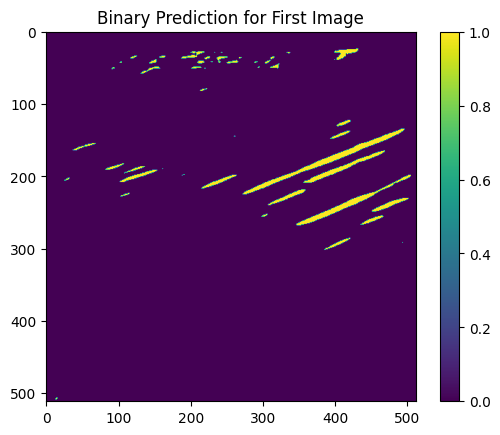

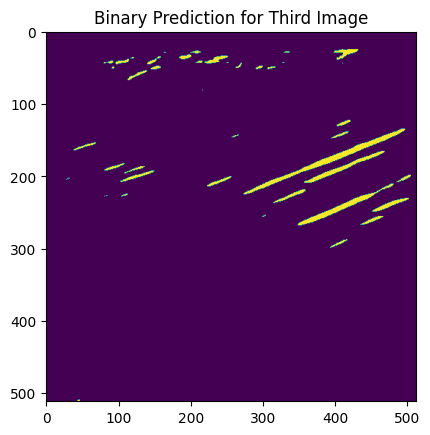

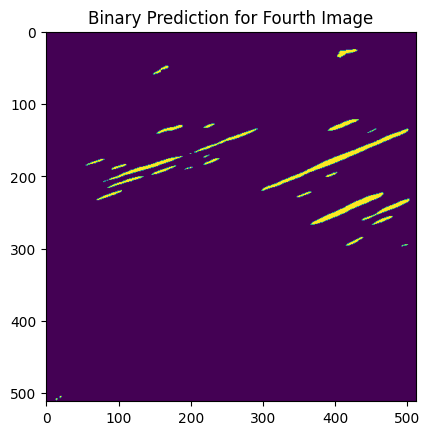

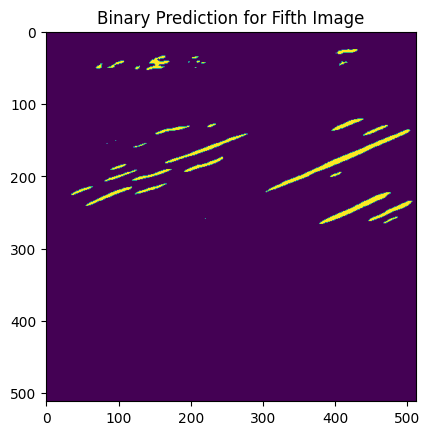

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the predictions are in the range [0, 1], not [0, 255]
predictions = np.array(predictions)

# Apply threshold for binary prediction (0.5 is typical for probabilities in range [0, 1])
threshold = 0.3
predictions_thresh = (predictions > threshold).astype(np.float32)

# Print the shape of the binary predictions
print(predictions_thresh.shape)

# Visualize the first prediction (binary mask)
im = plt.imshow(predictions_thresh[0, :, :, 0], cmap='viridis')
plt.colorbar(im)
plt.title("Binary Prediction for First Image")
plt.show()

# Visualize the second prediction (binary mask)
plt.imshow(predictions_thresh[1, :, :, 0], cmap='viridis')
plt.title("Binary Prediction for Third Image")
plt.show()

plt.imshow(predictions_thresh[24, :, :, 0], cmap='viridis')
plt.title("Binary Prediction for Fourth Image")
plt.show()

plt.imshow(predictions_thresh[42, :, :, 0], cmap='viridis')
plt.title("Binary Prediction for Fifth Image")
plt.show()




## Create video to check flow

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob

# Assuming predictions is already defined
predictions = np.array(predictions)

# Apply threshold for binary prediction (0.5 is typical for probabilities in range [0, 1])
threshold = 0.6
predictions_thresh = (predictions > threshold).astype(np.float32)

# Print the shape of the binary predictions
print(predictions_thresh.shape)

# Create a directory to save the frames
os.makedirs('frames', exist_ok=True)

# Save each frame as an image
for i in range(predictions_thresh.shape[0]):
    plt.imshow(predictions_thresh[i, :, :, 0], cmap='viridis')
    plt.title(f"Binary Prediction for Image {i+1}")
    plt.axis('off')
    plt.savefig(f'frames/frame_{i:04d}.png', bbox_inches='tight')
    plt.close()

# Get the list of frames
frame_files = sorted(glob.glob('frames/frame_*.png'))

# Read the first frame to get the dimensions
frame = cv2.imread(frame_files[0])
height, width, layers = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 file
video = cv2.VideoWriter('predictions_video.mp4', fourcc, 60, (width, height))  # 1 FPS

# Write each frame to the video
for frame_file in frame_files:
    frame = cv2.imread(frame_file)
    video.write(frame)

# Release the video writer
video.release()

print("Video saved as predictions_video.mp4")

(565, 512, 512, 2)
Video saved as predictions_video.mp4
